In [ ]:
'''
author: 叶文涛
create time: 2020-6-27
update time: 2020-7-16
'''

In [1]:
#-*- coding: UTF-8 -*-
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold, GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
pd.options.display.max_columns=50
pd.options.display.max_rows=20

In [2]:
# baseline只用到gps定位数据，即train_gps_path
train_gps_path = 'data/clean_data1.pkl'
test_data_path = 'data/R2 ATest 0711.csv'
order_data_path = 'data/loadingOrderEvent.csv'
port_data_path = 'data/port.csv'

In [3]:
%time train_data = pd.read_pickle(train_gps_path) #读取
train_data.drop(['diff_dist','diff_sec'], axis =1, inplace = True) # 去除cleandata中的两列
# 获取标签
train_data = train_data.merge(train_data.groupby('loadingOrder')['timestamp'].agg('max'), on = 'loadingOrder')
train_data['label'] = (train_data['timestamp_y'] - train_data['timestamp_x']).dt.total_seconds()
train_data['timestamp'] = train_data['timestamp_x']
#train_data = train_data.drop(['timestamp_x', 'diff_dist', 'diff_sec', 'timestamp_y'], axis = 1)
train_data = train_data.drop(['timestamp_x', 'timestamp_y'], axis = 1)

Wall time: 12.8 s


In [5]:
train_data

,loadingOrder,carrierName,longitude,latitude,vesselMMSI,speed,direction,vesselNextport,vesselNextportETA,vesselStatus,vesselDatasource,TRANSPORT_TRACE,label,timestamp
0,AA191175561416,OIEQNT,114.260392,22.571047,Y7540547327,0,12670,HK HKG >CN YTN,2019-01-28T05:30:00.000Z,moored,Coastal AIS,CNYTN-MXZLO,2255196.0,2019-01-28 16:12:59+00:00
1,AA191175561416,OIEQNT,114.260438,22.571125,Y7540547327,0,14790,HK HKG >CN YTN,2019-01-28T05:30:00.000Z,moored,Coastal AIS,CNYTN-MXZLO,2254617.0,2019-01-28 16:22:38+00:00
2,AA191175561416,OIEQNT,114.260693,22.571567,Y7540547327,0,21510,HK HKG >CN YTN,2019-01-28T05:30:00.000Z,moored,Coastal AIS,CNYTN-MXZLO,2254120.0,2019-01-28 16:30:55+00:00
3,AA191175561416,OIEQNT,114.260392,22.571463,Y7540547327,0,19900,HK HKG >CN YTN,2019-01-28T05:30:00.000Z,moored,Coastal AIS,CNYTN-MXZLO,2253720.0,2019-01-28 16:37:35+00:00
4,AA191175561416,OIEQNT,114.260647,22.571510,Y7540547327,0,21360,HK HKG >CN YTN,2019-01-28T05:30:00.000Z,moored,Coastal AIS,CNYTN-MXZLO,2253219.0,2019-01-28 16:45:56+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29612150,ZZ824778274922,HMKTVZ,136.794000,35.026833,F1868908205,5,28670,JP NGO,2020-04-03T03:00:00.000Z,under way using engine,Coastal AIS,CNSHK-JPNGO,490.0,2020-03-04 05:14:21+00:00
29612151,ZZ824778274922,HMKTVZ,136.792333,35.027167,F1868908205,2,27440,JP NGO,2020-04-03T03:00:00.000Z,under way using engine,Coastal AIS,CNSHK-JPNGO,360.0,2020-03-04 05:16:31+00:00
29612152,ZZ824778274922,HMKTVZ,136.791667,35.027000,F1868908205,2,22580,JP NGO,2020-04-03T03:00:00.000Z,under way using engine,Coastal AIS,CNSHK-JPNGO,240.0,2020-03-04 05:18:31+00:00
29612153,ZZ824778274922,HMKTVZ,136.791000,35.026833,F1868908205,0,25740,JP NGO,2020-04-03T03:00:00.000Z,under way using engine,Coastal AIS,CNSHK-JPNGO,110.0,2020-03-04 05:20:41+00:00


In [6]:
def get_data(data, mode='train'):
    
    assert mode=='train' or mode=='test'
    
    if mode=='train':
        data['vesselNextportETA'] = pd.to_datetime(data['vesselNextportETA'], infer_datetime_format=True)
    elif mode=='test':
        data['temp_timestamp'] = data['timestamp']
        data['onboardDate'] = pd.to_datetime(data['onboardDate'], infer_datetime_format=True)
    data['timestamp'] = pd.to_datetime(data['timestamp'], infer_datetime_format=True)
    data['longitude'] = data['longitude'].astype(float)
    data['loadingOrder'] = data['loadingOrder'].astype(str)
    data['latitude'] = data['latitude'].astype(float)
    data['speed'] = data['speed'].astype(float)
    data['direction'] = data['direction'].astype(float)

    return data

%time train_data = get_data(train_data, mode='train')

Wall time: 7.42 s


In [ ]:
# 差分特征效果不好
'''
# gps数据距离间隔（训练集）
%time diff_dist_gb = train_data.groupby(by=['loadingOrder']).apply(lambda x:Distance2(x['longitude'],x['latitude'],x['longitude'].shift(1),x['latitude'].shift(1)))
train_data['diff_dist'] = diff_dist_gb.reset_index(drop=True)
%time train_data['diff_sec'] = train_data.groupby(by=['loadingOrder'])['timestamp'].apply(lambda x:x.diff(1).dt.total_seconds())
%time train_data['diff_speed'] = train_data.groupby(by=['loadingOrder'])['speed'].apply(lambda x:x.diff(1))
%time train_data['diff_direction'] = train_data.groupby(by=['loadingOrder'])['direction'].apply(lambda x:x.diff(1))'''

In [7]:
# haversine 经纬度球面距离
def Distance2(LonA,LatA,LonB,LatB):
    EARTH_RADIUS = 6378.137 # 千米
    radLatA = np.radians(LatA)
    radLatB = np.radians(LatB)
    a = radLatA-radLatB
    b = np.radians(LonA)-np.radians(LonB)
    s= 2 * np.arcsin(np.sqrt(np.power(np.sin(a / 2),2)+ np.cos(radLatA) * np.cos(radLatB)*np.power(np.sin(b / 2),2))) * EARTH_RADIUS
    return s

# 始末点经纬度
tmp_df = train_data.groupby('loadingOrder')['longitude'].agg(['first','last']).reset_index().rename(columns = {'first':'start_lon', 'last':'end_lon'})
%time train_data = train_data.merge(tmp_df, on = 'loadingOrder', how = 'left')
tmp_df = train_data.groupby('loadingOrder')['latitude'].agg(['first','last']).reset_index().rename(columns = {'first':'start_lat', 'last':'end_lat'})
%time train_data = train_data.merge(tmp_df, on = 'loadingOrder', how = 'left')
# 利用始末经纬度和当前经纬度计算距离
train_data['dist_to_start']=Distance2(train_data['start_lon'],train_data['start_lat'],train_data['longitude'],train_data['latitude'])
train_data['dist_to_end']=Distance2(train_data['end_lon'],train_data['end_lat'],train_data['longitude'],train_data['latitude'])
train_data['dist_start_to_end']=Distance2(train_data['start_lon'],train_data['start_lat'],train_data['end_lon'],train_data['end_lat'])

Wall time: 15.2 s
Wall time: 16.8 s


In [8]:
test_data = pd.read_csv(test_data_path)
%time test_data = get_data(test_data, mode='test')
# 始末点经纬度
tmp_df = test_data.groupby('loadingOrder')['longitude'].agg(['first','last']).reset_index().rename(columns = {'first':'start_lon', 'last':'end_lon'})
test_data = test_data.merge(tmp_df, on = 'loadingOrder', how = 'left')
tmp_df = test_data.groupby('loadingOrder')['latitude'].agg(['first','last']).reset_index().rename(columns = {'first':'start_lat', 'last':'end_lat'})
test_data = test_data.merge(tmp_df, on = 'loadingOrder', how = 'left')
# 利用始末经纬度和当前经纬度计算距离
test_data['dist_to_start']=Distance2(test_data['start_lon'],test_data['start_lat'],test_data['longitude'],test_data['latitude'])
test_data['dist_to_end']=Distance2(test_data['end_lon'],test_data['end_lat'],test_data['longitude'],test_data['latitude'])
test_data['dist_start_to_end']=Distance2(test_data['start_lon'],test_data['start_lat'],test_data['end_lon'],test_data['end_lat'])

Wall time: 83.8 ms


In [9]:
# labelencode
for col in ['vesselMMSI', 'TRANSPORT_TRACE', 'carrierName']:
    lbl = LabelEncoder()
    lbl.fit(pd.concat([train_data, test_data])[col])
    %time train_data[col] = lbl.fit_transform(train_data[col].astype(str))
    test_data[col] = lbl.fit_transform(test_data[col].astype(str))

Wall time: 6.61 s
Wall time: 6.36 s
Wall time: 6.34 s


In [10]:
train_data

,loadingOrder,carrierName,longitude,latitude,vesselMMSI,speed,direction,vesselNextport,vesselNextportETA,vesselStatus,vesselDatasource,TRANSPORT_TRACE,label,timestamp,start_lon,end_lon,start_lat,end_lat,dist_to_start,dist_to_end,dist_start_to_end
0,AA191175561416,12,114.260392,22.571047,1517,0.0,12670.0,HK HKG >CN YTN,2019-01-28 05:30:00+00:00,moored,Coastal AIS,590,2255196.0,2019-01-28 16:12:59+00:00,114.260392,-104.299630,22.571047,19.059593,0.000000,13787.817244,13787.817244
1,AA191175561416,12,114.260438,22.571125,1517,0.0,14790.0,HK HKG >CN YTN,2019-01-28 05:30:00+00:00,moored,Coastal AIS,590,2254617.0,2019-01-28 16:22:38+00:00,114.260392,-104.299630,22.571047,19.059593,0.009887,13787.807771,13787.817244
2,AA191175561416,12,114.260693,22.571567,1517,0.0,21510.0,HK HKG >CN YTN,2019-01-28 05:30:00+00:00,moored,Coastal AIS,590,2254120.0,2019-01-28 16:30:55+00:00,114.260392,-104.299630,22.571047,19.059593,0.065636,13787.754499,13787.817244
3,AA191175561416,12,114.260392,22.571463,1517,0.0,19900.0,HK HKG >CN YTN,2019-01-28 05:30:00+00:00,moored,Coastal AIS,590,2253720.0,2019-01-28 16:37:35+00:00,114.260392,-104.299630,22.571047,19.059593,0.046309,13787.784609,13787.817244
4,AA191175561416,12,114.260647,22.571510,1517,0.0,21360.0,HK HKG >CN YTN,2019-01-28 05:30:00+00:00,moored,Coastal AIS,590,2253219.0,2019-01-28 16:45:56+00:00,114.260392,-104.299630,22.571047,19.059593,0.057823,13787.762325,13787.817244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29612150,ZZ824778274922,6,136.794000,35.026833,288,5.0,28670.0,JP NGO,2020-04-03 03:00:00+00:00,under way using engine,Coastal AIS,255,490.0,2020-03-04 05:14:21+00:00,113.897500,136.790833,22.461500,35.026833,2626.182334,0.288696,2625.922973
29612151,ZZ824778274922,6,136.792333,35.027167,288,2.0,27440.0,JP NGO,2020-04-03 03:00:00+00:00,under way using engine,Coastal AIS,255,360.0,2020-03-04 05:16:31+00:00,113.897500,136.790833,22.461500,35.026833,2626.062144,0.141701,2625.922973
29612152,ZZ824778274922,6,136.791667,35.027000,288,2.0,22580.0,JP NGO,2020-04-03 03:00:00+00:00,under way using engine,Coastal AIS,255,240.0,2020-03-04 05:18:31+00:00,113.897500,136.790833,22.461500,35.026833,2625.999438,0.078265,2625.922973
29612153,ZZ824778274922,6,136.791000,35.026833,288,0.0,25740.0,JP NGO,2020-04-03 03:00:00+00:00,under way using engine,Coastal AIS,255,110.0,2020-03-04 05:20:41+00:00,113.897500,136.790833,22.461500,35.026833,2625.936649,0.015223,2625.922973


In [11]:
test_data

,loadingOrder,timestamp,longitude,latitude,speed,direction,carrierName,vesselMMSI,onboardDate,TRANSPORT_TRACE,temp_timestamp,start_lon,end_lon,start_lat,end_lat,dist_to_start,dist_to_end,dist_start_to_end
0,QM149151037282,2019-01-11 04:18:28+00:00,114.337167,22.556333,28.0,10680.0,14,97,2019-01-11 04:18:28,75,2019-01-11T04:18:28.000Z,114.337167,114.123500,22.556333,22.324167,0.000000,33.930058,33.930058
1,QM149151037282,2019-01-11 04:39:08+00:00,114.426632,22.508475,30.0,13140.0,14,97,2019-01-11 04:18:28,75,2019-01-11T04:39:08.000Z,114.337167,114.123500,22.556333,22.324167,10.630291,37.337069,33.930058
2,QM149151037282,2019-01-11 06:05:48+00:00,114.418000,22.182000,27.0,22210.0,14,97,2019-01-11 04:18:28,75,2019-01-11T06:05:48.000Z,114.337167,114.123500,22.556333,22.324167,42.493259,34.221180,33.930058
3,QM149151037282,2019-01-11 08:48:28+00:00,114.101650,22.314968,15.0,4420.0,14,97,2019-01-11 04:18:28,75,2019-01-11T08:48:28.000Z,114.337167,114.123500,22.556333,22.324167,36.182442,2.472162,33.930058
4,QM149151037282,2019-01-11 09:50:58+00:00,114.123500,22.324167,0.0,7310.0,14,97,2019-01-11 04:18:28,75,2019-01-11T09:50:58.000Z,114.337167,114.123500,22.556333,22.324167,33.930058,0.000000,33.930058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77649,RA164708092311,2020-06-22 23:21:24+00:00,113.607726,18.704520,36.0,19700.0,10,151,2020-06-22 09:41:22,80,2020-06-22T23:21:24.000Z,114.274783,113.562748,22.563248,18.547645,435.133629,18.096323,453.130486
77650,RA164708092311,2020-06-22 23:40:51+00:00,113.577220,18.601798,35.0,19500.0,10,151,2020-06-22 09:41:22,80,2020-06-22T23:40:51.000Z,114.274783,113.562748,22.563248,18.547645,446.934915,6.218700,453.130486
77651,RA164708092311,2020-06-22 23:42:43+00:00,113.577220,18.601798,35.0,19500.0,10,151,2020-06-22 09:41:22,80,2020-06-22T23:42:43.000Z,114.274783,113.562748,22.563248,18.547645,446.934915,6.218700,453.130486
77652,RA164708092311,2020-06-22 23:51:23+00:00,113.562748,18.547645,35.0,19500.0,10,151,2020-06-22 09:41:22,80,2020-06-22T23:51:23.000Z,114.274783,113.562748,22.563248,18.547645,453.130486,0.000000,453.130486


In [ ]:
# 查看训练集与测试集特征分布
plt.subplots(6,4,figsize=(15,25))
for idx,col in enumerate(test_data.columns[2:-1]):
    plt.subplot(6,4,idx+1)
    plt.title(col)
    sns.kdeplot(train_data[col],label='train')
    sns.kdeplot(test_data[col],label='test')


In [12]:
def mse_score_eval(preds, valid):
    labels = valid.get_label()
    scores = mean_squared_error(y_true=labels/3600, y_pred=preds/3600)
    return 'mse_score', scores, False

def build_model(train, test, pred, label):
    train_pred = np.zeros((train.shape[0], ))
    test_pred = np.zeros((test.shape[0], ))
    n_splits = 2
    # params
    params = {
        'learning_rate': 0.1,
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'num_leaves': 36,
        'feature_fraction': 0.6,
        'bagging_fraction': 0.7,
        'bagging_freq': 6,
        'seed': 6666,
        'bagging_seed': 1,
        'feature_fraction_seed': 7,
        'min_data_in_leaf': 31,
        'nthread': 8,
        'device':'cpu'
    }
    
    # GroupKFold
    gkf = GroupKFold(n_splits=n_splits)
    # train
    for train_idx, valid_idx in gkf.split(train, train[label], groups=train['loadingOrder']):
        train_x, train_y = train[pred].iloc[train_idx], train[label].iloc[train_idx]
        valid_x, valid_y = train[pred].iloc[valid_idx], train[label].iloc[valid_idx]
        # 数据加载
        n_train = lgb.Dataset(train_x, label=train_y)
        n_valid = lgb.Dataset(valid_x, label=valid_y)

        clf = lgb.train(
            params=params,
            train_set=n_train,
            num_boost_round=300,
            valid_sets=[n_valid],
            early_stopping_rounds=30,
            verbose_eval=10,
            feval=mse_score_eval
        )
        train_pred[valid_idx] = clf.predict(valid_x, num_iteration=clf.best_iteration)
        test_pred += clf.predict(test[pred], num_iteration=clf.best_iteration)/n_splits
        
    test['label'] = test_pred
    lgb.plot_importance(clf, max_num_features = 20, importance_type = 'gain')
    print('oof MSE: ',mean_squared_error(train[label]/3600,train_pred/3600))
    print('test_label均值',np.mean(test['label']/3600))
    print('train_label均值',np.mean(train['label']/3600))
    return test[['loadingOrder', 'label']]



In [13]:
features = [c for c in train_data.columns if c not in ['loadingOrder', 'timestamp', 'label', 'vesselNextportETA', 'vesselNextport', 'vesselStatus', 'vesselDatasource']]
features

['carrierName',
 'longitude',
 'latitude',
 'vesselMMSI',
 'speed',
 'direction',
 'TRANSPORT_TRACE',
 'start_lon',
 'end_lon',
 'start_lat',
 'end_lat',
 'dist_to_start',
 'dist_to_end',
 'dist_start_to_end']

In [14]:
features = ['carrierName',
 'longitude',
 'latitude',
 'vesselMMSI',
 'end_lon',
 'end_lat',
 'speed',
 'direction',
 'TRANSPORT_TRACE',
 'dist_to_end']

Training until validation scores don't improve for 30 rounds
[10]	valid_0's l2: 3.40247e+11	valid_0's mse_score: 26253.6
[20]	valid_0's l2: 2.05821e+11	valid_0's mse_score: 15881.2
[30]	valid_0's l2: 1.70742e+11	valid_0's mse_score: 13174.5
[40]	valid_0's l2: 1.59502e+11	valid_0's mse_score: 12307.3
[50]	valid_0's l2: 1.52352e+11	valid_0's mse_score: 11755.6
[60]	valid_0's l2: 1.45751e+11	valid_0's mse_score: 11246.2
[70]	valid_0's l2: 1.41843e+11	valid_0's mse_score: 10944.7
[80]	valid_0's l2: 1.39941e+11	valid_0's mse_score: 10797.9
[90]	valid_0's l2: 1.39002e+11	valid_0's mse_score: 10725.5
[100]	valid_0's l2: 1.36816e+11	valid_0's mse_score: 10556.8
[110]	valid_0's l2: 1.35516e+11	valid_0's mse_score: 10456.5
[120]	valid_0's l2: 1.33445e+11	valid_0's mse_score: 10296.6
[130]	valid_0's l2: 1.33079e+11	valid_0's mse_score: 10268.4
[140]	valid_0's l2: 1.31984e+11	valid_0's mse_score: 10184
[150]	valid_0's l2: 1.31204e+11	valid_0's mse_score: 10123.8
[160]	valid_0's l2: 1.30259e+11	val

[630]	valid_0's l2: 1.25917e+11	valid_0's mse_score: 9715.82
[640]	valid_0's l2: 1.25907e+11	valid_0's mse_score: 9715.03
[650]	valid_0's l2: 1.2592e+11	valid_0's mse_score: 9716.03
[660]	valid_0's l2: 1.25803e+11	valid_0's mse_score: 9706.98
[670]	valid_0's l2: 1.25692e+11	valid_0's mse_score: 9698.46
[680]	valid_0's l2: 1.25686e+11	valid_0's mse_score: 9698.01
[690]	valid_0's l2: 1.25678e+11	valid_0's mse_score: 9697.35
Early stopping, best iteration is:
[667]	valid_0's l2: 1.25654e+11	valid_0's mse_score: 9695.5
oof MSE:  9523.774574658119
test_label均值 49.089727828338106
train_label均值 328.1675363342449


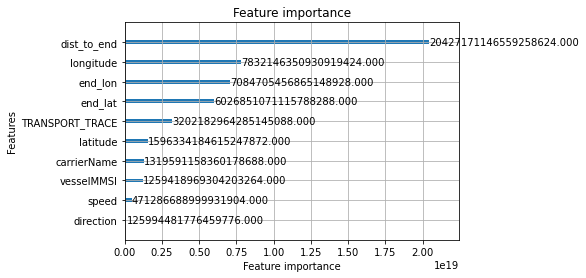

In [15]:
# baseline
result = build_model(train_data, test_data, features, 'label')

In [16]:
test_data = pd.read_csv(test_data_path)
test_data['label'] = result['label']
test_data = get_data(test_data, mode='test')  # 转换格式
test_data['ETA'] = (test_data['timestamp'] + test_data['label'].apply(lambda x:pd.Timedelta(seconds=x))).apply(lambda x:x.strftime('%Y/%m/%d  %H:%M:%S'))
test_data['onboardDate'] = test_data['onboardDate'].apply(lambda x:x.strftime('%Y/%m/%d  %H:%M:%S'))
test_data['creatDate'] = pd.datetime.now().strftime('%Y/%m/%d  %H:%M:%S')
test_data['timestamp'] = test_data['temp_timestamp']
# 整理columns顺序
result2 = test_data[['loadingOrder', 'timestamp', 'longitude', 'latitude', 'carrierName', 'vesselMMSI', 'onboardDate', 'ETA', 'creatDate']]

d:\tools\python\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [17]:
# 对ETF进行平均
def mean_ETA(df):
    df['ETA'] = pd.to_datetime(df['ETA'])
    df['ETA'] = [np.mean(df['ETA'])] * len(df)
    return df
result2 = result2.groupby('loadingOrder').apply(mean_ETA)
result2['ETA'] = result2['ETA'].apply(lambda x:x.strftime('%Y/%m/%d  %H:%M:%S'))

In [56]:
result2

,loadingOrder,timestamp,longitude,latitude,carrierName,vesselMMSI,onboardDate,ETA,creatDate
0,QM149151037282,2019-01-11T04:18:28.000Z,114.337167,22.556333,UQCRKD,Q4197827697,2019/01/11 04:18:28,2019/01/13 08:08:03,2020/07/16 22:57:12
1,QM149151037282,2019-01-11T04:39:08.000Z,114.426632,22.508475,UQCRKD,Q4197827697,2019/01/11 04:18:28,2019/01/13 08:08:03,2020/07/16 22:57:12
2,QM149151037282,2019-01-11T06:05:48.000Z,114.418000,22.182000,UQCRKD,Q4197827697,2019/01/11 04:18:28,2019/01/13 08:08:03,2020/07/16 22:57:12
3,QM149151037282,2019-01-11T08:48:28.000Z,114.101650,22.314968,UQCRKD,Q4197827697,2019/01/11 04:18:28,2019/01/13 08:08:03,2020/07/16 22:57:12
4,QM149151037282,2019-01-11T09:50:58.000Z,114.123500,22.324167,UQCRKD,Q4197827697,2019/01/11 04:18:28,2019/01/13 08:08:03,2020/07/16 22:57:12
...,...,...,...,...,...,...,...,...,...
77649,RA164708092311,2020-06-22T23:21:24.000Z,113.607726,18.704520,OYSCFP,Y1808674695,2020/06/22 09:41:22,2020/06/26 06:47:02,2020/07/16 22:57:12
77650,RA164708092311,2020-06-22T23:40:51.000Z,113.577220,18.601798,OYSCFP,Y1808674695,2020/06/22 09:41:22,2020/06/26 06:47:02,2020/07/16 22:57:12
77651,RA164708092311,2020-06-22T23:42:43.000Z,113.577220,18.601798,OYSCFP,Y1808674695,2020/06/22 09:41:22,2020/06/26 06:47:02,2020/07/16 22:57:12
77652,RA164708092311,2020-06-22T23:51:23.000Z,113.562748,18.547645,OYSCFP,Y1808674695,2020/06/22 09:41:22,2020/06/26 06:47:02,2020/07/16 22:57:12


In [43]:
pd.read_csv('result/result_2020-7-15_21-23.csv')

,loadingOrder,timestamp,longitude,latitude,carrierName,vesselMMSI,onboardDate,ETA,creatDate
0,QM149151037282,2019-01-11T04:18:28.000Z,114.337167,22.556333,UQCRKD,Q4197827697,2019/01/11 04:18:28,2019/01/25 11:08:49,2020/07/15 21:21:43
1,QM149151037282,2019-01-11T04:39:08.000Z,114.426632,22.508475,UQCRKD,Q4197827697,2019/01/11 04:18:28,2019/01/25 11:08:49,2020/07/15 21:21:43
2,QM149151037282,2019-01-11T06:05:48.000Z,114.418000,22.182000,UQCRKD,Q4197827697,2019/01/11 04:18:28,2019/01/25 11:08:49,2020/07/15 21:21:43
3,QM149151037282,2019-01-11T08:48:28.000Z,114.101650,22.314968,UQCRKD,Q4197827697,2019/01/11 04:18:28,2019/01/25 11:08:49,2020/07/15 21:21:43
4,QM149151037282,2019-01-11T09:50:58.000Z,114.123500,22.324167,UQCRKD,Q4197827697,2019/01/11 04:18:28,2019/01/25 11:08:49,2020/07/15 21:21:43
...,...,...,...,...,...,...,...,...,...
77649,RA164708092311,2020-06-22T23:21:24.000Z,113.607726,18.704520,OYSCFP,Y1808674695,2020/06/22 09:41:22,2020/06/26 12:03:54,2020/07/15 21:21:43
77650,RA164708092311,2020-06-22T23:40:51.000Z,113.577220,18.601798,OYSCFP,Y1808674695,2020/06/22 09:41:22,2020/06/26 12:03:54,2020/07/15 21:21:43
77651,RA164708092311,2020-06-22T23:42:43.000Z,113.577220,18.601798,OYSCFP,Y1808674695,2020/06/22 09:41:22,2020/06/26 12:03:54,2020/07/15 21:21:43
77652,RA164708092311,2020-06-22T23:51:23.000Z,113.562748,18.547645,OYSCFP,Y1808674695,2020/06/22 09:41:22,2020/06/26 12:03:54,2020/07/15 21:21:43


In [18]:
# 计算label分布
def cal_label(best):
    onboardDate = best.groupby('loadingOrder')['onboardDate'].agg(mmax='max').reset_index()
    ETA=best.groupby('loadingOrder')['ETA'].agg(mmax='max').reset_index()
    return (pd.to_datetime(ETA['mmax'])-pd.to_datetime(onboardDate['mmax'])).dt.total_seconds()

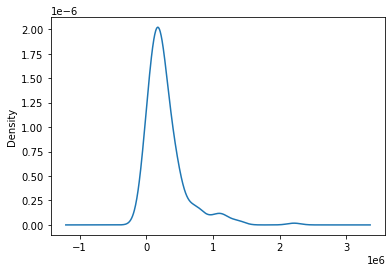

In [19]:
# baseline（未平均）
new=cal_label(result2)
new.plot(kind='kde')
plt.show()

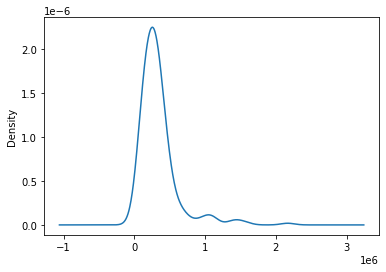

In [58]:
# baseline（已平均）
new=cal_label(result2)
new.plot(kind='kde')
plt.show()

In [21]:
import datetime
now = datetime.datetime.now()
result.to_csv('result/result_{0}-{1}-{2}_{3}-{4}.csv'.format(now.year,now.month,now.day,now.hour,now.minute), index=False)

In [ ]:
#given answer
GA_test_order_dict = {}
GA_test_order_dict['VT660611547333'] = '2020-03-13 23:39:28'
GA_test_order_dict['BR663094574600'] = '2020-06-01 21:08:03'
GA_test_order_dict['KD265061648304'] = '2020-06-01 14:31:43'
GA_test_order_dict['TI854412328664'] = '2020-06-01 05:29:08'
GA_test_order_dict['JE319829909965'] = '2020-01-04 17:34:28'
GA_test_order_dict['PK422158256377'] = '2020-06-01 22:55:26'